In [1]:
import pandas as pd 
import numpy as np
import pickle
from collections import defaultdict
import tensorflow as tf

def read_file(filename):
  with open(filename, "rb") as file:
      stat = pickle.load(file)
      file.close()
  return stat

def get_origin_path(stat):
    path_link = stat['data']['paths_link']
    od = [k for k in path_link.keys()]
    path1 = [tuple(p[0]) if len(p) > 0 else np.nan for p in path_link.values()]
    path2 = [tuple(p[1]) if len(p) > 1 else np.nan for p in path_link.values()]
    path3 = [tuple(p[2]) if len(p) > 2 else np.nan for p in path_link.values()]

    demand_dic = stat["data"]["demand"]
    demand = [v for v in demand_dic.values()]
    path_link_df = pd.DataFrame({"od": od, "demand":demand, "path1": path1, "path2": path2, "path3": path3})
    return path_link_df

def get_UE_link_cost(stat):
    # return a dataframe of link cost, link flow
    link = stat['data']['network'].copy()
    link['link_flow'] = stat['link_flow']
    # Calculate link cost
    link['link_cost'] = round(link['free_flow_time']*\
                            (1+link['b']*((link['link_flow']/link['capacity'])**4)), 2)
    return link

# Calculate path travel time for each od pair
def calculate_path_cost(row, link_df):
    if pd.isna(row): 
        return np.nan
    
    sum_time = 0
    for l in row:
        sum_time += link_df.at[l, 'link_cost']
    return round(sum_time, 2)

# calculate each link flow based on path flow
def extract_link_flow(path_link, flows):
    # input: a dictionary of {od pair: path_link} and list of flow distribution
    # return a dictionary of link flow
    path_flow = {}
    for path_set, flow_set in zip(path_link.values(), flows):
        for path, flow in zip(path_set, flow_set):
            path_flow[tuple(path)] = flow

    aggregated_sums = defaultdict(float)
    for path, flow in path_flow.items():
        for link in path:
            aggregated_sums[link] += flow
    link_flow = dict(aggregated_sums)
    return link_flow

# Check UE of origin dataset 
def mean_path_cost(filename):
    stat = read_file(filename)
    path_link_df = get_origin_path(stat)
    UE_link = get_UE_link_cost(stat)

    path_link_df['path1_cost'] = path_link_df['path1'].apply(lambda x: calculate_path_cost(x, UE_link))
    path_link_df['path2_cost'] = path_link_df['path2'].apply(lambda x: calculate_path_cost(x, UE_link))
    path_link_df['path3_cost'] = path_link_df['path3'].apply(lambda x: calculate_path_cost(x, UE_link))

    flows = stat['path_flow']
    path_link_df['flow1'] = [f[0] if len(f)>0 else 0 for f in flows]
    path_link_df['flow2'] = [f[1] if len(f)>1 else 0 for f in flows]
    path_link_df['flow3'] = [f[2] if len(f)>2 else 0 for f in flows]

    mean_path_cost = (np.nanmean(path_link_df['path1_cost']) + np.nanmean(path_link_df['path2_cost']) + np.nanmean(path_link_df['path3_cost']))/3
    return UE_link, path_link_df, mean_path_cost

def sum_pred_link_flow(pred_df, stat):
    pred_path_flow = pred_df[['flow1', 'flow2', 'flow3']].values.tolist()
    path_link = stat['data']['paths_link']

    pred_link_flow = extract_link_flow(path_link, pred_path_flow)
    pred_link_flow = pd.DataFrame.from_dict(pred_link_flow, orient='index', columns=['link_flow']).sort_index(ascending=True).reset_index()
    pred_link_flow.rename(columns={'index': 'link_id'}, inplace=True)
    link = stat['data']['network'].copy()[['link_id', 'capacity', 'free_flow_time', 'b']]
    output = pd.merge(link, pred_link_flow, how='left', on='link_id')
    output = output.fillna(0)
    output['link_cost'] = round(output['free_flow_time']*\
                            (1+output['b']*((output['link_flow']/output['capacity'])**4)), 2)
    return output

def calculate_delay(pred_df, pred_link_flow):
    pred_df['path1_cost'] = pred_df['path1'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path2_cost'] = pred_df['path2'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path3_cost'] = pred_df['path3'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['min_path_cost'] = pred_df[['path1_cost', 'path2_cost', 'path3_cost']].min(axis=1)
    pred_df['delay'] = (
        pred_df['flow1'] * (pred_df['path1_cost'] - pred_df['min_path_cost']) +
        pred_df['flow2'] * (pred_df['path2_cost'] - pred_df['min_path_cost']) +
        pred_df['flow3'] * (pred_df['path3_cost'] - pred_df['min_path_cost'])
    )
    avg_delay = pred_df['delay'].sum()/pred_df['demand'].sum()
    #return average delay in minutes
    return avg_delay

import networkx as nx 
import matplotlib.pyplot as plt 

def create_synthetic_graph(edges):
    G = nx.DiGraph()
    for edge in edges:
        G.add_edge(edge[0], edge[1], capacity=edge[2])
    return G

def plot_graph_with_heatmap(G, pos):
    edge_capacities = [G[u][v]['capacity'] for u, v in G.edges]
    min_capacity = min(edge_capacities)
    max_capacity = max(edge_capacities)
    print("Min: ",min_capacity)
    print("Max: ",max_capacity)
    norm = plt.Normalize(vmin=min_capacity, vmax=max_capacity)

    plt.figure(figsize=(10, 8))
    cmap = plt.cm.RdYlGn_r
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_capacities,
                                   width = 3, arrows=True,
                                   edge_cmap=cmap,
                                   connectionstyle='arc3,rad=0.05',
                                   edge_vmin=min_capacity,
                                   edge_vmax=max_capacity)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=200, node_color='white', edgecolors='black')
    labels = nx.draw_networkx_labels(G, pos, font_color='black', font_size=8)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    ax = plt.gca()
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Link Capacity', fontsize=17)
    cbar.ax.tick_params(labelsize=15)
    plt.show()

Min:  1015
Max:  1992


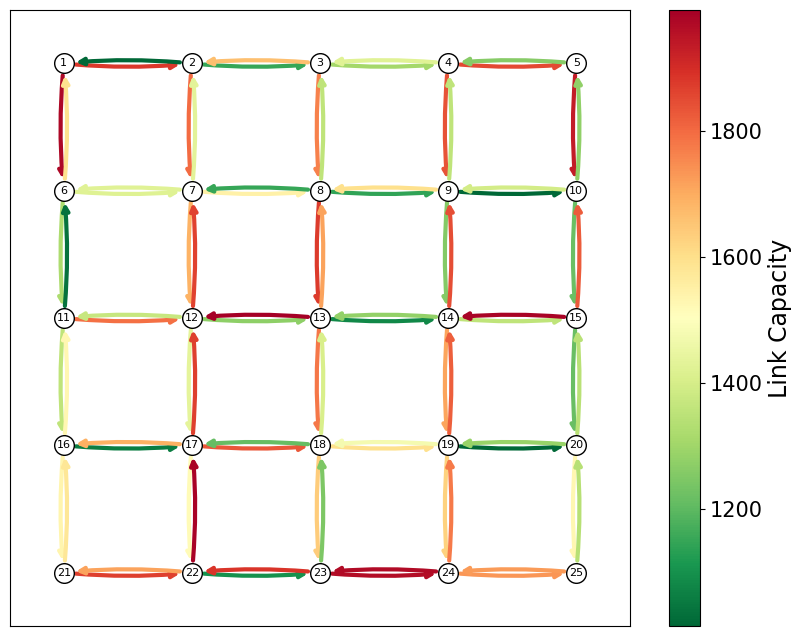

In [36]:
filename = '../Solution/Random/Output1/5by5_Data0'
stat = read_file(filename)
nodes = stat['data']['network'][['link_id', 'init_node', 'term_node']]

edges = [(int(row['init_node']), int(row['term_node']), row['capacity']) for _, row in stat['data']['network'].iterrows()]
G = create_synthetic_graph(edges)
pos = {}
i = 1
for y in range(5):
    for x in range(5):
        pos[i] = (x, 4 - y)
        i += 1
plot_graph_with_heatmap(G, pos)

In [5]:
from tqdm import tqdm

sum_avg, cost = [], []
size = 10
for i in tqdm(range(size)):
    file_name = f"../Solution/Random_0/5by5_Data{i}"
    UE_link, df, mean_cost = mean_path_cost(file_name)
    delay = calculate_delay(df, UE_link)
    sum_avg.append(delay)
    cost.append(mean_cost)

delay = np.mean(sum_avg)
mean_cost = np.mean(cost)

print("Mean path cost: ", mean_cost, " hours")
print("Delay: ", delay, " hours = ", round(delay/mean_cost*100, 2), "%")

100%|██████████| 10/10 [00:01<00:00,  7.51it/s]

Mean path cost:  178.26960400000002  hours
Delay:  0.3731018545187438  hours =  0.21 %


In [13]:
a_file = open("../Generate_data/SiouxFalls/od_demand_list_4000.pkl", "rb")
output = pickle.load(a_file)
a_file.close()

od89 = []
od13 = []
aggregated_sums = defaultdict(float)
for i, od_demand in enumerate(output):
    for od, demand in od_demand.items():
        aggregated_sums[od] =+ np.mean(demand)
demand = dict(aggregated_sums)
# demand = dict(sorted(demand.values()))
demand

{(15, 21): 1478.0,
 (18, 17): 1722.0,
 (8, 9): 1053.0,
 (19, 9): 1586.0,
 (19, 18): 1375.0,
 (11, 14): 1626.0,
 (11, 23): 1022.0,
 (4, 2): 382.0,
 (22, 10): 811.0,
 (3, 6): 1060.0,
 (14, 15): 1642.0,
 (14, 24): 1877.0,
 (3, 24): 1878.0,
 (7, 3): 506.0,
 (15, 16): 187.0,
 (18, 12): 1537.0,
 (18, 21): 996.0,
 (7, 21): 1437.0,
 (8, 4): 503.0,
 (11, 9): 1603.0,
 (10, 22): 562.0,
 (22, 5): 587.0,
 (22, 14): 1005.0,
 (3, 10): 661.0,
 (14, 19): 423.0,
 (3, 19): 1538.0,
 (15, 2): 422.0,
 (18, 7): 719.0,
 (7, 16): 1396.0,
 (18, 16): 1442.0,
 (11, 4): 842.0,
 (10, 17): 1792.0,
 (2, 13): 745.0,
 (3, 5): 1809.0,
 (22, 18): 803.0,
 (3, 14): 1851.0,
 (14, 23): 1187.0,
 (18, 2): 1906.0,
 (7, 2): 745.0,
 (18, 11): 834.0,
 (21, 13): 423.0,
 (22, 13): 1384.0,
 (3, 9): 1719.0,
 (14, 18): 1977.0,
 (3, 18): 339.0,
 (17, 20): 819.0,
 (6, 10): 910.0,
 (21, 17): 1949.0,
 (10, 7): 666.0,
 (2, 3): 1453.0,
 (2, 21): 1482.0,
 (22, 8): 1595.0,
 (14, 4): 454.0,
 (3, 4): 238.0,
 (17, 6): 947.0,
 (9, 11): 1169.0,
 (1

In [15]:
print(demand[(8,9)])
print(demand[(13, 24)])

1053.0
362.0


In [23]:
# Average path cost

for j in range(4):
    sum_avg, cost = [], []
    size = 1000
    for i in tqdm(range(size)):
        file_name = f"../Solution/EMA/Output{j+1}/5by5_Data{i}"
        UE_link, df, mean_cost = mean_path_cost(file_name)
        delay = calculate_delay(df, UE_link)
        sum_avg.append(delay)
        cost.append(mean_cost)

    delay = np.mean(sum_avg)
    mean_cost = np.mean(cost)

    print("Mean path cost: ", mean_cost, " minutes")
    print("Delay: ", delay, " minutes = ", round(delay/mean_cost*100, 2), "%")

100%|██████████| 1000/1000 [00:19<00:00, 51.94it/s]


Mean path cost:  19.07080346052123  minutes
Delay:  0.004756556912802233  minutes =  0.02 %


100%|██████████| 1000/1000 [00:18<00:00, 52.65it/s]


Mean path cost:  27.37388129290902  minutes
Delay:  0.009307877732595261  minutes =  0.03 %


100%|██████████| 1000/1000 [00:19<00:00, 51.71it/s]


Mean path cost:  36.46728436752656  minutes
Delay:  0.008889134036467216  minutes =  0.02 %


100%|██████████| 1000/1000 [00:19<00:00, 52.52it/s]

Mean path cost:  98.87650931697874  minutes
Delay:  0.03522099576284346  minutes =  0.04 %


In [ ]:
filename = '../Solution/Output3/5by5_Data0'
stat = read_file(filename)
# a = get_UE_link_cost(stat)
UE_link, path_link_df, mean_path_cost = mean_path_cost(filename)
UE_link

# DRAW CHARTS

In [3]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def load_files_from_folders(folders, max_files):
    file_list = []
    for folder in folders:
        for i in range(max_files):
            file = ''.join([folder,str(f'/5by5_Data{i}')])
            file_list.append(file)
    return file_list

def normalize(tensor):
    scaler = MinMaxScaler()
    normed = scaler.fit_transform(tensor)
    return normed

def get_frequenceMatrix(path_link, net):
    frequency_dict = get_frequency(path_link)
    net['frequence'] = net['link_id'].apply(lambda x: map_frequence(x, frequency_dict))
    frequence = np.array(net[['init_node', 'term_node', 'frequence']]\
                         .apply(lambda row: ((row['init_node'], row['term_node']), row['frequence']), axis=1)\
                            .tolist(), dtype=object)
    # frequence = create_matrix(frequence, nodes)
    return frequence

def get_frequency(path_link):
    a = tuple(tuple(p) for path in path_link.values() for p in path)
    frequency_dict = {}
    for sublist in a:
        for value in sublist:
            if value in frequency_dict:
                frequency_dict[value] += 1
            else:
                frequency_dict[value] = 1
    frequency_dict = dict(sorted(frequency_dict.items()))
    return frequency_dict

def map_frequence(row, frequency_dict):
    if row in frequency_dict.keys():
        return frequency_dict[row]
    return 0

FOLDERS = [f'../Solution/SiouxFalls/Output{i+1}' for i in range(1)]
DATA_SIZE = 1000
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
demand, path_flow, frequence = [], [], []
od_pair = []

for filename in tqdm(files):
    stat = read_file(filename)
    demand_dic = stat["data"]["demand"]
    flows = stat["path_flow"]
    path_links = stat["data"]["paths_link"]
    d = np.array(list(demand_dic.values())).reshape(-1, 1)
    demand.append(normalize(d).flatten().tolist())
    # demand.append(demand_dic.values())
    od_pair.append(len(demand_dic.keys()))
    path_flow.append([flow for flow in flows])
    f = get_frequency(path_links).values()
    frequence.append(f)
demand = [i for j in demand for i in j]

flow = [j for i in path_flow for j in i]

f1 = [f[0] for f in flow if f[0]>10]
f2 = [f[1] for f in flow if f[1]>10]
f3 = [f[2] for f in flow if f[2]>10]

100%|██████████| 1000/1000 [00:57<00:00, 17.36it/s]


In [15]:
FOLDERS = ['../Solution/SiouxFalls/Output2'] # 73 links = 5%
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
path_flow2 = []
for filename in tqdm(files):
    stat = read_file(filename)
    flows = stat["path_flow"]
    path_flow2.append([flow for flow in flows])

flow2 = [j for i in path_flow2 for j in i]

f12 = [f[0] for f in flow2 if f[0]>10]
f22 = [f[1] if len(f) > 1 else 0 for f in flow2]
f32 = [f[2] if len(f) > 2 else 0 for f in flow2]
f22 = [f for f in f22 if f>10]
f32 = [f for f in f32 if f>10]

100%|██████████| 1000/1000 [00:54<00:00, 18.38it/s]


In [16]:
FOLDERS = ['../Solution/SiouxFalls/Output3'] # 70 links = 10%
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
path_flow3 = []
for filename in tqdm(files):
    stat = read_file(filename)
    flows = stat["path_flow"]
    path_flow3.append([flow for flow in flows])

flow3 = [j for i in path_flow3 for j in i]

f13 = [f[0] for f in flow3 if f[0]>10]
f23 = [f[1] if len(f) > 1 else 0 for f in flow3]
f33 = [f[2] if len(f) > 2 else 0 for f in flow3]
f23 = [f for f in f23 if f>10]
f33 = [f for f in f33 if f>10]

100%|██████████| 1000/1000 [00:51<00:00, 19.50it/s]


/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

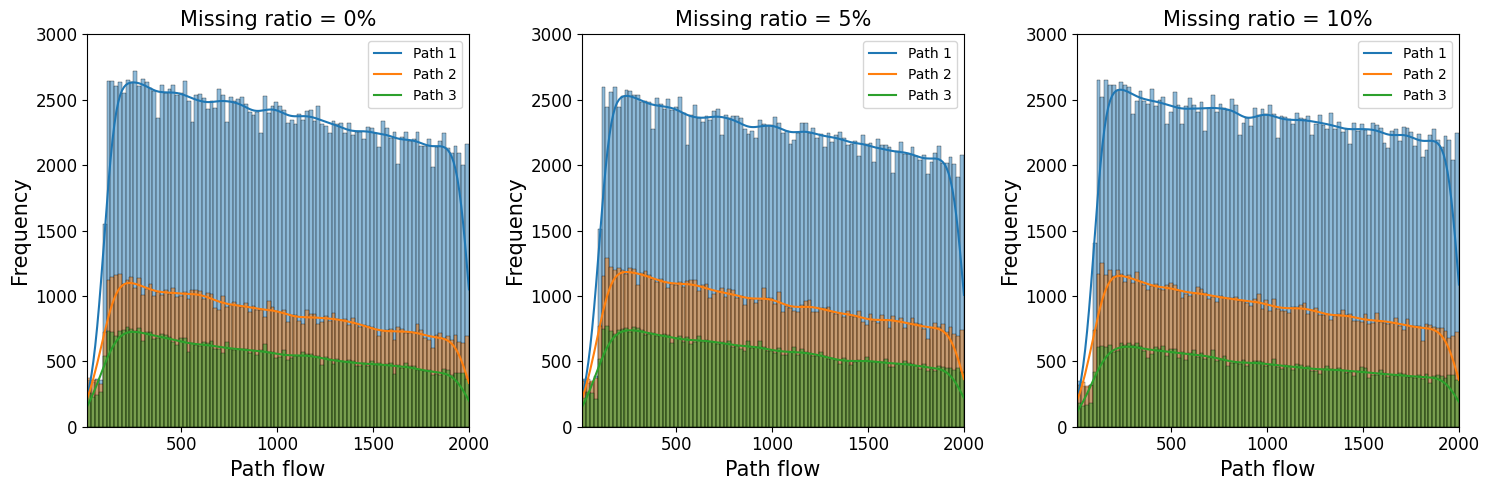

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# f1 = np.array(f1).reshape(-1, 1)
# f2 = np.array(f2).reshape(-1, 1)
# f3 = np.array(f3).reshape(-1, 1)

plt.figure(figsize=(15, 5))
plt.subplot(1,3, 1)
sns.histplot(f1, bins=100, kde=True)
sns.histplot(f2, bins=100, kde=True)
sns.histplot(f3, bins=100, kde=True)
plt.xlim(10, 2000)
plt.ylim(0,3000)
plt.title("Missing ratio = 0%", fontsize=15)
plt.xlabel('Path flow', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.legend(['Path 1', 'Path 2', 'Path 3'])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,3, 2)
sns.histplot(f12, bins=100, kde=True)
sns.histplot(f22, bins=100, kde=True)
sns.histplot(f32, bins=100, kde=True)
plt.xlim(10, 2000)
plt.ylim(0,3000)
plt.title("Missing ratio = 5%", fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Path flow', fontsize=15)
plt.legend(['Path 1', 'Path 2', 'Path 3'])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,3, 3)
sns.histplot(f13, bins=100, kde=True)
sns.histplot(f23, bins=100, kde=True)
sns.histplot(f33, bins=100, kde=True)
plt.xlim(10, 2000)
plt.ylim(0,3000)
plt.title("Missing ratio = 10%", fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Path flow', fontsize=15)
plt.legend(['Path 1', 'Path 2', 'Path 3'])
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

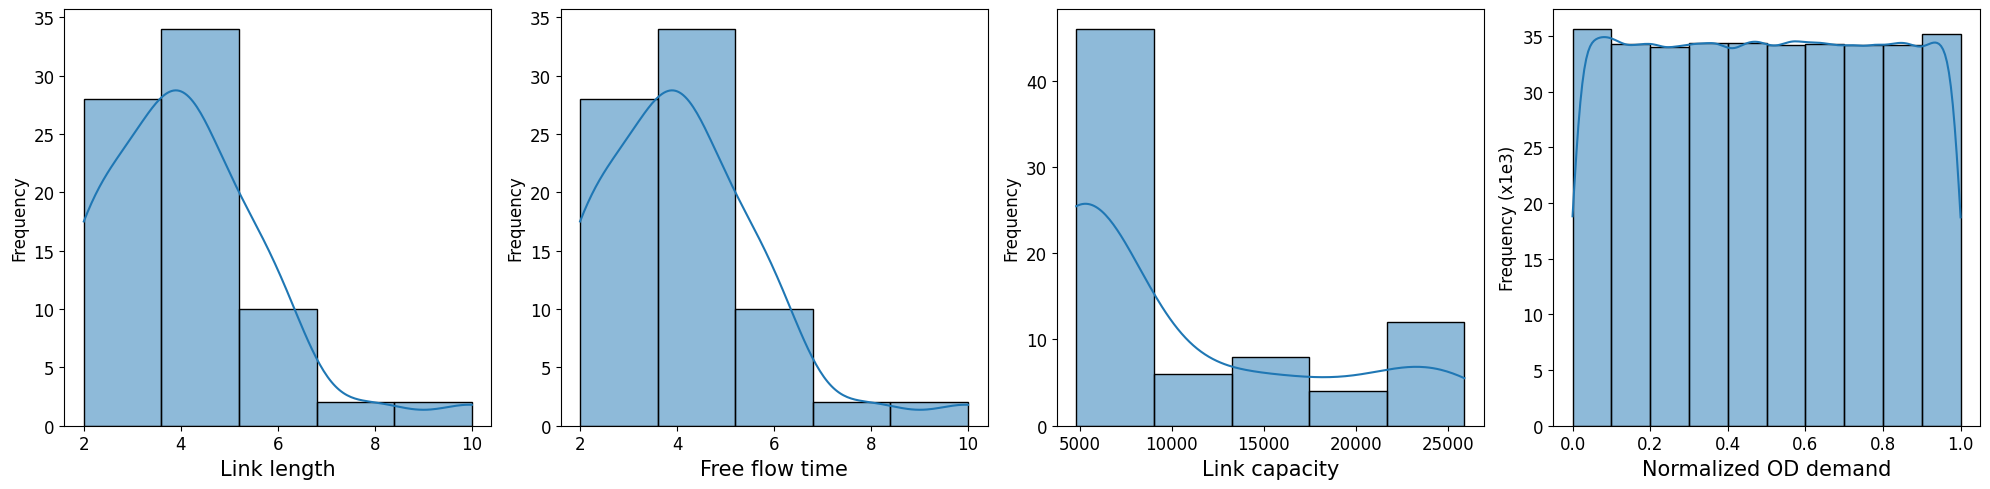

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

stat = read_file('../Solution/SiouxFalls/Output1/5by5_Data0')
net = stat["data"]["network"]
cap = net['capacity']
leng = net['length']
fft = net['free_flow_time']
c = np.array(cap).reshape(-1, 1)
f = [j for i in frequence for j in i]
f = np.array(f).reshape(-1, 1)

def thousands_formatter(x, pos):
    return '%1.0f' % (x * 1e-3)

plt.figure(figsize=(20, 5))

plt.subplot(1,4, 1)
sns.histplot(leng, bins=5, kde=True)
plt.xlabel('Link length', fontsize=15)
plt.ylabel('Frequency', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,4, 2)
sns.histplot(fft, bins=5, kde=True)
plt.xlabel('Free flow time', fontsize=15)
plt.ylabel('Frequency', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,4, 3)
sns.histplot(c.flatten(), bins=5, kde=True)
plt.xlabel('Link capacity', fontsize=15)
plt.ylabel('Frequency', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,4, 4)
sns.histplot(demand, bins=10, kde=True)
plt.xlabel('Normalized OD demand', fontsize=15)
plt.ylabel('Frequency (x1e3)', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# plt.subplot(2,3, 5)
# sns.histplot(normalize(f).flatten(), bins=10, kde=True)
# plt.xlabel('Normalized Link frequency')
# plt.ylabel('Frequency')

# plt.subplot(2,3, 6)
# sns.histplot(od_pair, bins=8, kde=True)
# plt.xlabel('Number of OD pairs')
# plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd

FOLDERS = [f'../SiouxFalls/Output{i}' for i in list([1,2,3])]
DATA_SIZE = 1000

Link_flow, Link_id= [], []
for folder in FOLDERS:
    link_flow, link_id = [], []
    for i in range(DATA_SIZE):
        file = ''.join([folder,str(f'/5by5_Data{i}')])
        stat = read_file(file)
        link_id.append(stat['data']['network']['link_id'])
        link_flow.append(stat['link_flow'])
    Link_flow.append(link_flow)
    Link_id.append(link_id)

/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

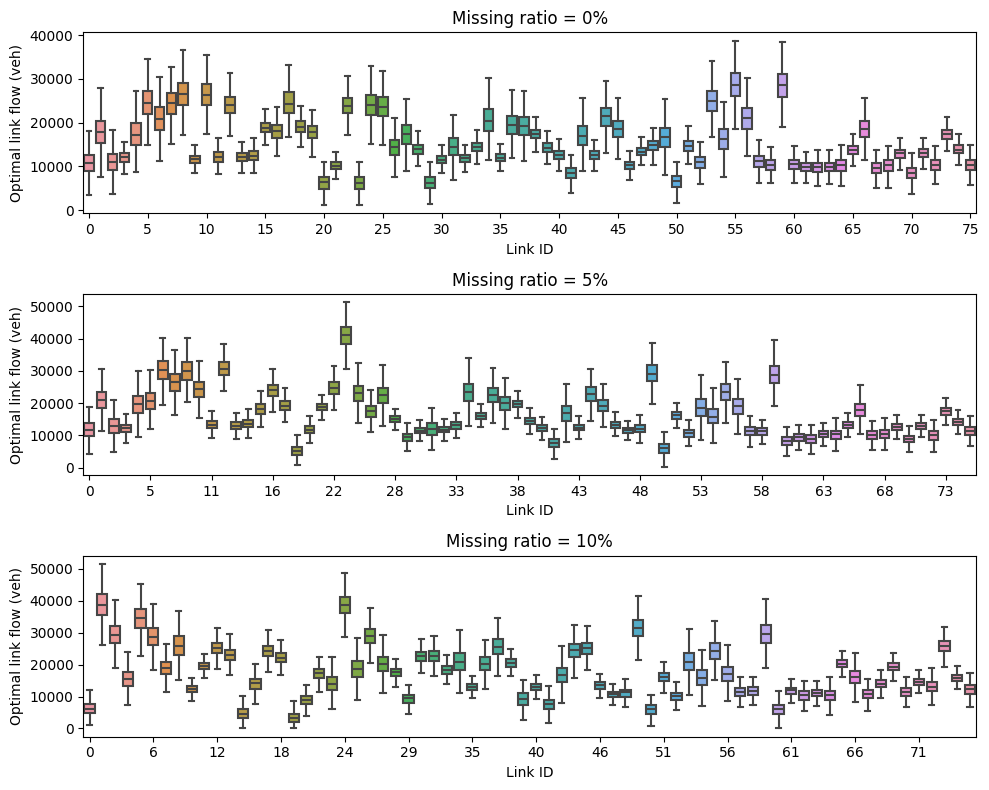

In [12]:
output1 = pd.DataFrame(Link_flow[0], columns=(Link_id[0][0])) # full network
output2 = pd.DataFrame(Link_flow[1], columns=(Link_id[1][0])) # remove 5%
output3 = pd.DataFrame(Link_flow[2], columns=(Link_id[2][0])) # remove 10%

plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
sns.boxplot(data=output1, showfliers=False)
plt.xticks(np.arange(0, 76, step=5)) 
plt.title('Missing ratio = 0%')
plt.ylabel('Optimal link flow (veh)')
plt.xlabel('Link ID')

plt.subplot(3,1,2)
sns.boxplot(data=output2, showfliers=False)
plt.xticks(np.arange(0, 73, step=5)) 
plt.title('Missing ratio = 5%')
plt.ylabel('Optimal link flow (veh)')
plt.xlabel('Link ID')

plt.subplot(3,1,3)
sns.boxplot(data=output3, showfliers=False)
plt.xticks(np.arange(0, 70, step=5)) 
plt.title('Missing ratio = 10%')
plt.ylabel('Optimal link flow (veh)')
plt.xlabel('Link ID')

plt.tight_layout()
plt.show()